In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!unzip "/content/drive/My Drive/data.zip"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Archive:  /content/drive/My Drive/data.zip
   creating: data/davis/
  inflating: data/davis/drug-drug_similarities_2D.txt  
  inflating: data/davis/drug-target_interaction_affinities_Kd__Davis_et_al.2011v1.txt  
   creating: data/davis/folds/
  inflating: data/davis/folds/test_fold_setting1.txt  
  inflating: data/davis/folds/train_fold_setting1.txt  
  inflating: data/davis/ligands_can.txt  
  inflating: data/davis/ligands_iso.txt  
  inflating: data/davis/pr

In [2]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv1d, MaxPool1d, Module, Softmax, BatchNorm1d, Dropout, Tanh
from torch.optim import Adam, SGD
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import math



In [68]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
  device = torch.device("cpu")
  print("Running on the CPU")

Running on the GPU


In [109]:
DATASET = 'davis'

def pre_process_SMILE(mode):

  final_SMILES = []
  char_num = {}
  SMILES_length = 0
  if mode == 'kiba':
    SMILES_length = 100
  if mode == 'davis':
    SMILES_length = 95

  with open("/content/data/"+DATASET+"/ligands_iso.txt") as fp:
    line = fp.readline()
    SMILES = line.split(",")
    final_SMILES = [j.replace('"',"") for j in [k.replace(' ','') for k in [i.split(":")[1] for i in SMILES]]]
    final_SMILES[-1] = final_SMILES[-1].replace("}","")
  unique_set = list(set([j for i in final_SMILES for j in i]))
  for n, i in enumerate(unique_set):
    char_num[i] = n + 1
  pre_procesed_SMILES = []
  for i in final_SMILES:
    x = []
    for j in i:
      x.append(char_num[j])
    if len(x) > SMILES_length:
      x = x[:SMILES_length]
    elif len(x) < SMILES_length:
      for j in range(SMILES_length - len(x)):
        x.append(0)

    pre_procesed_SMILES.append(x)
  return pre_procesed_SMILES

pre_procesed_SMILES = pre_process_SMILE(DATASET)
print(len(pre_procesed_SMILES))


68


In [110]:
def pre_process_proteins(mode):
  char_num = {}
  proteins_length = 0
  word_length = 3
  if mode == 'kiba':
    proteins_length = 450
  if mode == 'davis':
    proteins_length = 450

  with open("/content/data/"+DATASET+"/proteins.txt") as fp:
    line = fp.readline()
    proteins = line.split(",")
    final_proteins = [j.replace('"',"") for j in [k.replace(' ','') for k in [i.split(":")[1] for i in proteins]]]
    final_proteins[-1] = final_proteins[-1].replace("}","")
    print("number of proteins :", len(final_proteins))

  unique_word = {}
  for protein in final_proteins:
    for n in range(0,(len(protein)-word_length+1),word_length):
      if protein[n:n+word_length] not in unique_word:
        unique_word[protein[n:n+word_length]] = 1
      else:
        unique_word[protein[n:n+word_length]]+=1

  unique_word = {k: v for k, v in sorted(unique_word.items(), key=lambda item: item[1])}
  word_num = {}
  for n, i in enumerate(list(unique_word)):
    word_num[i] = n + 1
  
  pre_procesed_proteins = []
  length = []
  for protein in final_proteins:
    x = []
    for n in range(0,(len(protein)-word_length+1),word_length):
      x.append(word_num[protein[n:n+word_length]])
    length.append(len(x))
    if len(x) > proteins_length:
      x = x[:proteins_length]
    elif len(x) < proteins_length:
      for j in range(proteins_length - len(x)):
        x.append(0)
    pre_procesed_proteins.append(x)
  return pre_procesed_proteins, length


def check_good_length(length):
  plt.hist(length, len(length))
  plt.show()
  selected = []
  for i in length:
    if i <= 450:
      selected.append(i)
  if len(selected)/len(length) > 0.85:
    print(len(selected)/len(length),"good")

pre_procesed_proteins, length = pre_process_proteins(DATASET)


  

number of proteins : 442


In [111]:
class data(Dataset):
  def __init__(self, data, y):
    self.y = pd.DataFrame(y)
    self.data = pd.DataFrame(data)

  def __getitem__(self, index):
    
    data = np.array(self.data.loc[index])
    label = np.array(self.y.loc[index])
    sample = (data ,label)
    return sample

  def __len__(self):
    self.len = self.data.shape
    return len(self.data)
import random

def over_under_sampling(major_part_indices, under_rate, minor_class_index, over_rate, middle_class_index, middle_rate):
  
  index_value = random.sample(major_part_indices,int(len(major_part_indices)/under_rate ))
  x = []
  for i in range(over_rate):
    x+=minor_class_index
  x1 = []
  for i in range(middle_rate):
    x1+=middle_class_index
  
  return index_value+x+x1

batch_size = 256

label = pickle.load(open("/content/data/"+DATASET+"/Y", "rb"), encoding='latin1')
label_f_no_log = label[~np.isnan(label)]
if DATASET == "davis":
  label_f = -(np.log10(label_f_no_log/(math.pow(10,9))+0.00000001))
if DATASET == 'kiba':
  label_f = label_f_no_log
label_row_inds, label_col_inds = np.where(np.isnan(label)==False)
test_fold = json.load(open("/content/data/"+DATASET+"/folds/test_fold_setting1.txt"))
train_fold = json.load(open("/content/data/"+DATASET+"/folds/train_fold_setting1.txt"))

validation_fold = train_fold[4]
train_fold = [j for i in train_fold[:4] for j in i ]
major_class_index = []  
minor_class_index = []
middle_class_index = []  
train_y = []
if DATASET == 'davis':
  for i in train_fold:
    if 4.9 <= label_f[i] <= 5.1:
      major_class_index.append(i)  
    else:
      if  5.1 < label_f[i] < 7:
        middle_class_index.append(i)
      else:
        minor_class_index.append(i)
  new_train_fold = over_under_sampling(major_class_index,3,minor_class_index, 6, middle_class_index, 1)
if DATASET == 'kiba':
  new_train_fold = train_fold


train_drug_indices = label_row_inds[new_train_fold]
train_protein_indices = label_col_inds[new_train_fold]
test_drug_indices = label_row_inds[test_fold]
test_protein_indices = label_col_inds[test_fold]
validation_drug_indices = label_row_inds[validation_fold]
validation_protein_indices = label_col_inds[validation_fold]

smile_train_data = []
for i in train_drug_indices:
  smile_train_data.append(pre_procesed_SMILES[i])

protein_train_data = []
for i in train_protein_indices:
  protein_train_data.append(pre_procesed_proteins[i])

smile_test_data = []
for i in test_drug_indices:
  smile_test_data.append(pre_procesed_SMILES[i])

protein_test_data = []
for i in test_protein_indices:
  protein_test_data.append(pre_procesed_proteins[i])

smile_validation_data = []
for i in validation_drug_indices:
  smile_validation_data.append(pre_procesed_SMILES[i])

protein_validation_data = []
for i in validation_protein_indices:
  protein_validation_data.append(pre_procesed_proteins[i])
  
train_y = []
for i in new_train_fold:
  train_y.append(label_f[i])

test_y = []
for i in test_fold:
  test_y.append(label_f[i])

validation_y = []
for i in validation_fold:
  validation_y.append(label_f[i])
  
train_set_p = data(protein_train_data, train_y)
train_loader_p = DataLoader(dataset=train_set_p,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True)

train_set_s = data(smile_train_data, train_y)
train_loader_s = DataLoader(dataset=train_set_s,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True)


test_set_p = data(protein_test_data, test_y)
test_loader_p = DataLoader(dataset=test_set_p,
                        batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

test_set_s = data(smile_test_data, test_y)
test_loader_s = DataLoader(dataset=test_set_s,
                        batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)  


validation_set_p = data(protein_validation_data, validation_y)
validation_loader_p = DataLoader(dataset=validation_set_p,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

validation_set_s = data(smile_validation_data, validation_y)
validation_loader_s = DataLoader(dataset=validation_set_s,
                        batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)  


In [112]:
class CNN(nn.Module):
  def __init__(self):
      super(CNN, self).__init__()

      self.cnn_layers = Sequential(
          Conv1d(1, 32, kernel_size=4, stride=2, padding=0),
          BatchNorm1d(32),
          ReLU(inplace=True),
          Conv1d(32, 64, kernel_size=8, stride=2, padding=0),
          ReLU(inplace=True),
          MaxPool1d(3, stride=2), 
              
      )
    
  def forward(self, x):
    x = x.float()
    x = self.cnn_layers(x)
    x = x.view(x.size(0), -1)
    return x

class CNN2(nn.Module):
  def __init__(self):
      super(CNN2, self).__init__()

      self.cnn_layers = Sequential(
          Conv1d(1, 32, kernel_size=4, stride=2, padding=0),
          BatchNorm1d(32),
          ReLU(inplace=True),
          Conv1d(32, 64, kernel_size=8, stride=2, padding=0),
          BatchNorm1d(64),
          ReLU(inplace=True),
          Conv1d(64, 96, kernel_size=12, stride=2, padding=0),
          ReLU(inplace=True),
          MaxPool1d(4, stride=3), 
              
      )
      self.relu = nn.ReLU()
      
  
  def forward(self, x):
    x = x.float()
    x = self.cnn_layers(x)
    x = x.view(x.size(0), -1)
    return x


class MyModel(nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()
        self.input_dim = 1
        self.hidden_dim = 256
        self.target_dim = 1
        self.batch_size = 256
        self.p_len = 450
        
        if DATASET == "davis":
          self.input_n = 576
          self.s_len = 95
        if DATASET == "kiba":
          self.input_n = 640
          self.s_len = 100
          
        self.cnn = CNN()
        self.cnn2 = CNN2()
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, batch_first = True, num_layers = 1) 
        #384 448    
        self.linear1 = nn.Linear(self.input_n + self.hidden_dim,1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 1)
        self.relu = nn.ReLU()
        self.dropout = Dropout(0.1)
        
    def forward(self, x1, x2):
       
        h0 = torch.zeros(1, self.batch_size, self.hidden_dim).requires_grad_()
        h0 = h0.to(device)
        c0 = torch.zeros(1, self.batch_size, self.hidden_dim).requires_grad_()
        c0 = c0.to(device)

        x1 = x1.float()
        x2 = x2.float()

        c_in = x2.view(self.batch_size, 1, self.s_len)
        SMILEs = self.cnn(c_in)

        c_in_2 = x1.view(self.batch_size, 1, self.p_len)
        pre_proteins = self.cnn2(c_in_2)    
        lstm_in = pre_proteins.view(len(x1), 1536, -1)
        proteins, (hn, cn) = self.lstm(lstm_in, (h0.detach(), c0.detach()))
       
        proteins = proteins[:,-1,:]
        concatination = torch.cat((SMILEs, proteins), 1)
        out1 = self.linear1(concatination)
        relu_out1 = self.relu(out1)
        relu_out1 = self.dropout(relu_out1)
        out2 = self.linear2(relu_out1)
        relu_out2 = self.relu(out2)
        relu_out2 = self.dropout(relu_out2)
        y_pred = self.linear3(relu_out2)

        
        return y_pred



In [115]:

def weighted_mse_loss(input, target, weight):
    return torch.mean(torch.matmul(weight, (input - target)**2))

final_model = MyModel()
final_model = final_model.to(device)
print(final_model)
if DATASET == 'davis':
  criterion = nn.MSELoss()
  criterion.to(device)
if DATASET == 'kiba':
  criterion = weighted_mse_loss

optimizer = torch.optim.AdamW(final_model.parameters(), lr = 0.0001)

MyModel(
  (cnn): CNN(
    (cnn_layers): Sequential(
      (0): Conv1d(1, 32, kernel_size=(4,), stride=(2,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(32, 64, kernel_size=(8,), stride=(2,))
      (4): ReLU(inplace=True)
      (5): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (cnn2): CNN2(
    (cnn_layers): Sequential(
      (0): Conv1d(1, 32, kernel_size=(4,), stride=(2,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(32, 64, kernel_size=(8,), stride=(2,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv1d(64, 96, kernel_size=(12,), stride=(2,))
      (7): ReLU(inplace=True)
      (8): MaxPool1d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (r

In [116]:
epoch_num = 15

train_log = []
val_log = []
x = 0

for epoch in range(1, epoch_num+1):
  train_loss = []
  val_loss = []
  final_model.train()
  for batch_idx1, ((datap, target), (datas, target)) in enumerate(zip(train_loader_p, train_loader_s)):  
    datap = datap.to(device)
    datas = datas.to(device)
    target = target.float()
    target = target.to(device)
    optimizer.zero_grad()
    output = final_model(datap,datas)
    w = []
    for i in target:
      if 11 <= i <= 12.5:
        w.append(0.8)
      else:
        w.append(1.2) 
    w = Variable(torch.FloatTensor(w), requires_grad = True).to(device)
    if DATASET == 'davis':
      loss = criterion(output, target)
    if DATASET == 'kiba':
      loss = criterion(output, target,w)
    loss.backward()                
    optimizer.step() 
    train_loss.append(loss.item()) 
  print('>> Epoch: ',epoch,">> Train loss: ",np.mean(train_loss))
  train_log.append(np.mean(train_loss))
 
for batch_idx1, ((datap, target), (datas, target)) in enumerate(zip(validation_loader_p, validation_loader_s)):  
  datap = datap.to(device)
  datas = datas.to(device)
  target = target.float()
  target = target.to(device)
  output = final_model(datap,datas)
  if DATASET == 'davis':
      loss = criterion(output, target)
  if DATASET == 'kiba':
    loss = criterion(output, target,w)
  val_loss.append(loss.item()) 
print(">> Validation loss: ",np.mean(val_loss))
val_log.append(np.mean(val_loss))


>> Epoch:  1 >> Train loss:  9.536286131976402
>> Epoch:  2 >> Train loss:  1.3117984516979897
>> Epoch:  3 >> Train loss:  1.2100816671162435
>> Epoch:  4 >> Train loss:  1.1256956025345686
>> Epoch:  5 >> Train loss:  1.0643657045821622
>> Epoch:  6 >> Train loss:  1.028726242176474
>> Epoch:  7 >> Train loss:  1.0077253163677373
>> Epoch:  8 >> Train loss:  1.0016438013886753
>> Epoch:  9 >> Train loss:  0.9978334119875137
>> Epoch:  10 >> Train loss:  0.9940990152424329
>> Epoch:  11 >> Train loss:  0.9953964589393303
>> Epoch:  12 >> Train loss:  0.9899729180009398
>> Epoch:  13 >> Train loss:  0.9847485153642419
>> Epoch:  14 >> Train loss:  0.9924592914646619
>> Epoch:  15 >> Train loss:  0.9867014754308413
>> Validation loss:  1.1038782439733807


In [117]:
y_true = []
y_pred = []


with torch.no_grad():
    final_model.eval()
    for batch_idx1, ((datap, labels), (datas, labels)) in enumerate(zip(test_loader_p, test_loader_s)):  
        datap = datap.to(device)
        datas = datas.to(device)
        target = target.float()
        target = target.to(device)      
        outputs = final_model(datap, datas) 
        y_true += labels.tolist()
        y_pred += outputs.tolist()
y_true = np.array(y_true)
y_pred = np.array(y_pred)
print(len(y_true))
print(len(y_pred))
mse = np.square(np.subtract(y_true,y_pred)).mean() 
print('MSE: ', mse)


4864
4864
MSE:  1.0954824523253428


In [53]:
def get_cindex(Y, P):
    summ = 0
    pair = 0
    
    for i in range(1, len(Y)):
        for j in range(0, i):
            if i is not j:
                if(Y[i] > Y[j]):
                    pair +=1
                    summ +=  1* (P[i] > P[j]) + 0.5 * (P[i] == P[j])
        
            
    if pair is not 0:
        return summ/pair
    else:
        return 0

CI = get_cindex(y_true, y_pred)
print("CI: ",CI)

CI:  [0.72238992]


In [118]:
from sklearn.metrics import f1_score, precision_recall_fscore_support
def confusion_matrix(y_true, y_pred):
  TP, TN, FP, FN = 0, 0, 0, 0
  for i,j in zip(y_true, y_pred):
    if i == j == 1:
      TP+=1
    if i == j == 0:
      TN+=1
    if i == 0 and j == 1:
      FP+=1
    if i == 1 and j == 0:
      FN+=1
  return TP, TN, FP, FN

if DATASET == 'davis':
  y_true_classification = [1 if i>=7 else 0 for i in y_true]
  y_pred_classification = [1 if i>=7 else 0 for i in y_pred]

if DATASET == 'kiba':
  y_true_classification = [1 if i>=12.1 else 0 for i in y_true]
  y_pred_classification = [1 if i>=12.1 else 0 for i in y_pred]

print(len(y_true_classification))
print(len(y_pred_classification))

f1_score = f1_score(y_true_classification, y_pred_classification)
a = precision_recall_fscore_support(y_true_classification, y_pred_classification, average='macro')
precision = a[0]
recall = a[1]
TP, TN, FP, FN = confusion_matrix(y_true_classification, y_pred_classification)
print(TP, TN, FP, FN)
sensitivity = TP/(TP+ FN)
specifity = TN/( TN + FP )
acc = (TP + TN) / (TP + TN + FP + FN)
print(sensitivity, specifity, acc, f1_score)
print(y_pred_classification)


4864
4864
153 4066 412 233
0.3963730569948187 0.9079946404644931 0.8673930921052632 0.3217665615141956
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

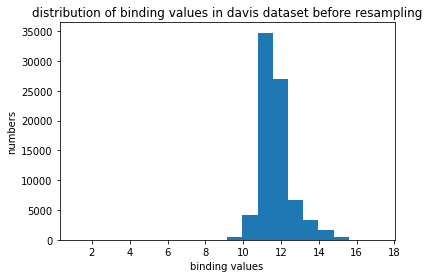

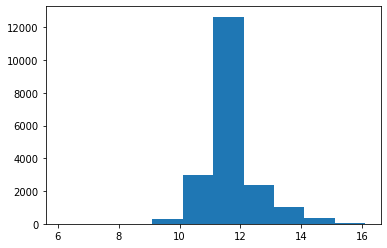

In [108]:
# x = [10 for i in train_y if i>= 11 and i<= 12]
plt.hist(train_y, 20)
plt.xlabel('binding values') 
plt.ylabel('numbers')
plt.title('distribution of binding values in davis dataset before resampling') 
plt.savefig("f.jpg")
plt.show() 
plt.show()
label_f_x = label_f / np.linalg.norm(label_f)

plt.hist(test_y, 10)
plt.show()

In [93]:
torch.save(final_model.state_dict(), "/content/myModel_final_d")

In [94]:

final_model = MyModel()
final_model.load_state_dict(torch.load("/content/myModel_final_d"))
# final_model.eval()
y_true = []
y_pred = []
device = torch.device("cuda")
final_model.to(device)

with torch.no_grad():
    final_model.eval()
    for batch_idx1, ((datap, labels), (datas, labels)) in enumerate(zip(test_loader_p, test_loader_s)):  
        datap = datap.to(device)
        datas = datas.to(device)
        target = target.float()
        target = target.to(device)      
        outputs = final_model(datap, datas) 
        y_true += labels.tolist()
        y_pred += outputs.tolist()
y_true = np.array(y_true)
y_pred = np.array(y_pred)
print(len(y_true))
print(len(y_pred))
mse = np.square(np.subtract(y_true,y_pred)).mean() 
print('MSE: ', mse)


4864
4864
MSE:  1.2707435469640374
